# Willkommen
Hier ein paar informationen:
* Am besten einfach alles einmal ausführen (mit der run all cells funktion, oder ganz oft SHIFT+ENTER drücken)
* Dann diese Kommentare lesen

In [1]:
if get_ipython().__class__.__module__ == "google.colab._shell":
    print("running in google colab, fetching resources")
    %pip install colorama
    !git clone https://github.com/bastinat0r/Plenardebatten.git
    path = "Plenardebatten/data"
else:
    path = "data"

In [2]:
import xml.etree.ElementTree as ET
import pandas as pd
import datetime
import glob, os
import seaborn as sns
import re
import matplotlib.pyplot as plt
from colorama import Fore
import numpy as np
import IPython

## Keywords
* Das sind die Keywords nach denen gesucht werden soll
* Keywords können später auch wieder gefiltert werden, also braucht man nicht zu sparen
* Ein keyword besteht aus 2 Teilen
  * Vorm Doppelpunkt ein "Name"
  * Hinter dem Doppelpunkt einige ["Suchbegriffe", "Einer geht auch"]
* Wichtig: Der Text der Plenardebatten wird vor dem Suchen bereinigt
  * Sonderzeichen wie ,.-? werden entfernt
  * Mehrere leerzeichen werden durch einzelne leerzeichen ersetzt
  * Alle Buchstaben werden zu kleinbuchstaben (also findet man unter "Klima" nichts unter "klima" schon mehr)
  * Aus "Herr Dr., was ist los?" wird zu "herr dr was ist los "
* Die Suchbegriffe sind Reguläre Ausdrücke - [Anleitung](https://de.wikibooks.org/wiki/Python_unter_Linux:_Reguläre_Ausdrücke#Ausdrücke_im_Überblick)

In [3]:
c11 = ["kohleausstieg", "kohleverstromung", "kohlekommission"]
c12 = ["erneuerbare", "energiewende", "windkraft", "windenergie", "solarstrom", "solarenergie", "grüne\senergie"]
c13 = ["co\s?2\s?reduktion", "co\s?2\s?preis", "co\s?2\s?bepreisung", "emissionshandel", "verschmutzungsrecht", "luftverschmutzung", "co\s2\szertifikate", "zertifikatehandel", "emissions\szertifikate", "co\s2\ssteuer"]
c14 = ["verkehrswende", "e\s?mobilität", "e\s?autos", "emissions\s?freier\sverkehr", "fahrverbote"]
c21 = ["klimaschutz", "klima\s?ziele", "1\s?5\s?(grad|c)\s?ziel", "pariser\sabkommen", "netto\s?null"]
c22 = ["klimakriese", "klimakatastrophe", "erderwärmung", "globale\s?erwärmung", "meeresspiegel", "klimawandel", "ipcc", "climate\schange"]
c31 = ["friday[s]?\s?for\s?future", "thunberg", "neubauer", "scientist[s]?\s?for\s?future", "klimastreik"]
c32 = ["extinction rebellion", "\sxr\s"]
c33 = ["hambacher forst", "hambi\s?bleibt"]
c34 = ["green\s?peace", "nabu", "wbf"]
c41 = ["schwänz[^\s]+", "no education", "schulpflicht"]
keywords={ 
    "C1.1: Kohle": c11,
    "C1.2: Energiewende": c12,
    "C1.3: Emission": c13,
    "C1.4: Verkehr": c14,
    "C2.1: Klimaschutz": c21,
    "C2.2: Klimakriese": c22,
    "C1: CO2": c11 + c12 + c13 + c14,
    "C2: Klima": c21 + c22,
    "C3: Bewegungen": c31 + c32 + c33 + c34,
    "C3.1: FFF": c31,
    "C3.2: XR": c32,
    "C3.3: Hambacher Forst": c33,
    "C3.4: NGOs": c34,
    "C4: Gegner": c41,
         }

pure_words = {v : [v] for v in c11 + c12 + c13 + c14 + c21 + c22 + c31 + c32 + c33 + c34 + c41}
keywords.update(pure_words)

In [4]:
keywords

{'C1.1: Kohle': ['kohleausstieg', 'kohleverstromung', 'kohlekommission'],
 'C1.2: Energiewende': ['erneuerbare',
  'energiewende',
  'windkraft',
  'windenergie',
  'solarstrom',
  'solarenergie',
  'grüne\\senergie'],
 'C1.3: Emission': ['co\\s?2\\s?reduktion',
  'co\\s?2\\s?preis',
  'co\\s?2\\s?bepreisung',
  'emissionshandel',
  'verschmutzungsrecht',
  'luftverschmutzung',
  'co\\s2\\szertifikate',
  'zertifikatehandel',
  'emissions\\szertifikate',
  'co\\s2\\ssteuer'],
 'C1.4: Verkehr': ['verkehrswende',
  'e\\s?mobilität',
  'e\\s?autos',
  'emissions\\s?freier\\sverkehr',
  'fahrverbote'],
 'C2.1: Klimaschutz': ['klimaschutz',
  'klima\\s?ziele',
  '1\\s?5\\s?(grad|c)\\s?ziel',
  'pariser\\sabkommen',
  'netto\\snull'],
 'C2.2: Klimakriese': ['klimakriese',
  'klimakatastrophe',
  'erderwärmung',
  'globale\\s?erwärmung',
  'meeresspiegel',
  'klimawandel',
  'ipcc',
  'climate\\schange'],
 'C1: CO2': ['kohleausstieg',
  'kohleverstromung',
  'kohlekommission',
  'erneuerbare'

In [5]:
# bereinigt ein stück text wie beschrieben
def clean(s):
    replacements = [".", ":", ",", "?", "!", "-", "(", ")", "–", ";", "/", "„", "“", "”", "\"", "#"]
    for r in replacements:
        s = s.replace(r, " ")
    whitespace = re.compile("\s+")
    s, _ = whitespace.subn(" ", s)
    return s.lower()

# liest und analysiert ein xml file
def df_from_xml(filename, keywords=keywords, startdate=None):
    tree = ET.parse(filename)
    root = tree.getroot()
    date = tree.find(".//datum").attrib["date"]
    nr = int(root.attrib["sitzung-nr"])
    periode = int(root.attrib["wahlperiode"])
    #print(nr)
    #print("  ", date)

    
    data = {}
    dataframes = []
            
    day = int(date.split(".")[0])
    month = int(date.split(".")[1])
    year = int(date.split(".")[2])
    data["date"] = datetime.date(year, month, day)
    if startdate is not None and data["date"] < startdate:
        return []
    data["sdate"] = date
    data["smonth"] = f"{month}-{year}"
    data["day"] = day
    data["year"] = year
    data["month"] = month
    data["nr"] = nr
    data["id"] = nr + 1000*periode
    
    for key, value in keywords.items():
        n = 0
        for word in value:
            matcher = re.compile(f"({word})")
            for p in root.findall(".//p"):
                text = ""
                if p.text is not None:
                    text = clean(p.text)
                found, num = matcher.subn(Fore.RED + r'\1' + Fore.RESET, text)
                if num > 0:
                    #print(f"{key}-{word}: {num}")
                    #print(found)
                    n += num
            
        data["word"] = key
        data["count"] = n
        dataframes.append(pd.DataFrame([data]))

    return dataframes

df = df_from_xml(f"{path}/19110-data.xml")
print(df)

[         date       sdate  smonth  day  year  month   nr     id         word  \
0  2019-09-10  10.09.2019  9-2019   10  2019      9  110  19110  C1.1: Kohle   

   count  
0     21  ,          date       sdate  smonth  day  year  month   nr     id  \
0  2019-09-10  10.09.2019  9-2019   10  2019      9  110  19110   

                 word  count  
0  C1.2: Energiewende     34  ,          date       sdate  smonth  day  year  month   nr     id  \
0  2019-09-10  10.09.2019  9-2019   10  2019      9  110  19110   

             word  count  
0  C1.3: Emission      1  ,          date       sdate  smonth  day  year  month   nr     id  \
0  2019-09-10  10.09.2019  9-2019   10  2019      9  110  19110   

            word  count  
0  C1.4: Verkehr      7  ,          date       sdate  smonth  day  year  month   nr     id  \
0  2019-09-10  10.09.2019  9-2019   10  2019      9  110  19110   

                word  count  
0  C2.1: Klimaschutz    118  ,          date       sdate  smonth  day  yea

In [6]:
# liest alle xml files im data ordner und analysiert die daten
files = glob.glob(f"{path}/*.xml")
data = []
failed = []
for f in files:
    try:
        print(f)
        data = data + df_from_xml(f, startdate=datetime.date(2018,1,9))
    except AttributeError:
        failed.append(f)
        print(f"problem with {f}")
df = pd.concat(data)
df.set_index("id", inplace=True)
df.sort_index(inplace=True)
df

data/19043-data.xml
data/19042-data.xml
data/19102-data.xml
data/19103-data.xml
data/19098-data.xml
data/19099-data.xml
data/19034-data.xml
data/19035-data.xml
data/19092-data.xml
data/19093-data.xml
data/19108-data.xml
data/19109-data.xml
data/19001-data.xml
data/19049-data.xml
data/19048-data.xml
data/19077-data.xml
data/19076-data.xml
data/19115-data.xml
data/19114-data.xml
data/19054-data.xml
data/19055-data.xml
data/19023-data.xml
data/19022-data.xml
data/19017-data.xml
data/19016-data.xml
data/19085-data.xml
data/19084-data.xml
data/19060-data.xml
data/19061-data.xml
data/19029-data.xml
data/19028-data.xml
data/19112-data.xml
data/19113-data.xml
data/19088-data.xml
data/19089-data.xml
data/19053-data.xml
data/19052-data.xml
data/19024-data.xml
data/19025-data.xml
data/19059-data.xml
data/19058-data.xml
data/19082-data.xml
data/19083-data.xml
data/19010-data.xml
data/19011-data.xml
data/19067-data.xml
data/19066-data.xml
data/19045-data.xml
data/19105-data.xml
data/19104-data.xml


date       sdate  smonth  day  year  month   nr  \
id                                                             
19006  2018-01-17  17.01.2018  1-2018   17  2018      1    6   
19006  2018-01-17  17.01.2018  1-2018   17  2018      1    6   
19006  2018-01-17  17.01.2018  1-2018   17  2018      1    6   
19006  2018-01-17  17.01.2018  1-2018   17  2018      1    6   
19006  2018-01-17  17.01.2018  1-2018   17  2018      1    6   
...           ...         ...     ...  ...   ...    ...  ...   
19116  2019-09-27  27.09.2019  9-2019   27  2019      9  116   
19116  2019-09-27  27.09.2019  9-2019   27  2019      9  116   
19116  2019-09-27  27.09.2019  9-2019   27  2019      9  116   
19116  2019-09-27  27.09.2019  9-2019   27  2019      9  116   
19116  2019-09-27  27.09.2019  9-2019   27  2019      9  116   

                              word  count  
id                                         
19006                schwänz[^\s]+      0  
19006                verkehrswende      0  
19006                e\s?mobilität      0  
19006                    e\s?autos      0  
19006  emissions\s?freier\sverkehr      0  
...                            ...    ...  
19116                    e\s?autos      2  
19116                e\s?mobilität      5  
19116                verkehrswende      1  
19116                meeresspiegel      0  
19116                 no education      0  

[7303 rows x 9 columns]

In [7]:
print(df["word"].unique())

['schwänz[^\\s]+' 'verkehrswende' 'e\\s?mobilität' 'e\\s?autos'
 'emissions\\s?freier\\sverkehr' 'fahrverbote' 'klimaschutz'
 'klima\\s?ziele' '1\\s?5\\s?(grad|c)\\s?ziel' 'pariser\\sabkommen'
 'netto\\snull' 'klimakriese' 'klimakatastrophe' 'globale\\s?erwärmung'
 'meeresspiegel' 'klimawandel' 'ipcc' 'climate\\schange' 'wbf' 'nabu'
 'no education' 'schulpflicht' 'green\\s?peace' 'hambi\\s?bleibt'
 'co\\s2\\ssteuer' 'hambacher forst' 'extinction rebellion' 'klimastreik'
 'scientist[s]?\\s?for\\s?future' 'neubauer' 'thunberg'
 'friday[s]?\\s?for\\s?future' '\\sxr\\s' 'emissions\\szertifikate'
 'erderwärmung' 'co\\s2\\szertifikate' 'zertifikatehandel'
 'C1.2: Energiewende' 'C1.3: Emission' 'C1.4: Verkehr' 'C2.1: Klimaschutz'
 'C2.2: Klimakriese' 'C1: CO2' 'C2: Klima' 'C3: Bewegungen' 'C3.1: FFF'
 'C3.2: XR' 'C3.3: Hambacher Forst' 'C3.4: NGOs' 'C4: Gegner'
 'kohleausstieg' 'C1.1: Kohle' 'kohlekommission' 'kohleverstromung'
 'verschmutzungsrecht' 'emissionshandel' 'co\\s?2\\s?bepreisung'


In [77]:
# filtert eine Liste von Keywords aus den Daten (alle anderen werden angezeigt)
def plotwords(words, title=None):
    df_filter = df.copy()
    df_filter = df_filter.loc[df_filter.word.isin( words )]
    #IPython.display.display_pretty(df_filter)

    if True:
        erste = datetime.date(2018,8,30)
        df_filter = df_filter.loc[df_filter.date > erste]

    # Erstellt eine Grafik aus den gefilterten Daten
    sns.set_style("whitegrid")
    sns.catplot(data=df_filter, y="date", x="count", hue="word", dodge=0.1, orient="h", kind="point", height=13, ci=None, estimator=np.sum)
    if title is not None:
        plt.title(title)
        plt.tight_layout()
        plt.savefig(f"figures/{title}_all.png", dpi=400)
    plt.show()
    sns.catplot(data=df_filter, y="smonth", x="count", hue="word", dodge=0.1, orient="h", kind="point", height=8, ci=None, estimator=np.sum)
    if title is not None:
        plt.title(title)
        plt.tight_layout()
        plt.savefig(f"figures/{title}_month.png", dpi=400)
    plt.show()

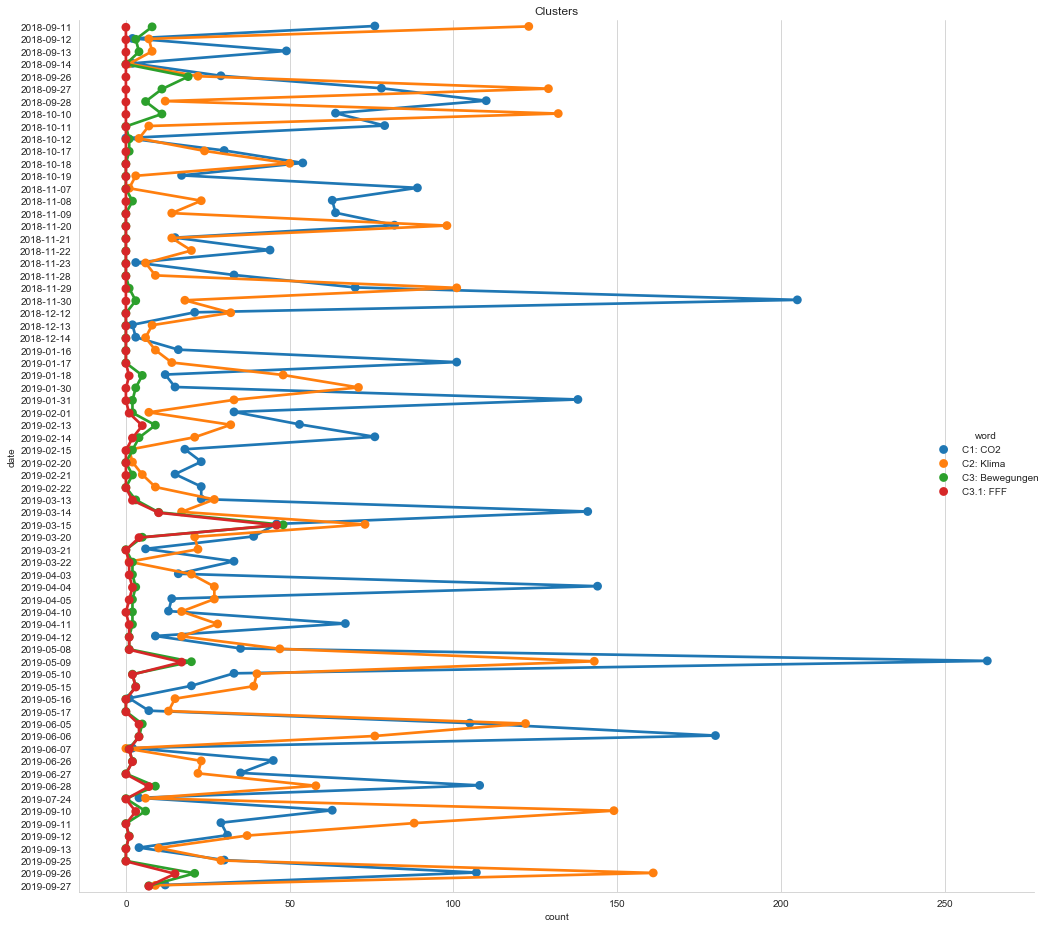

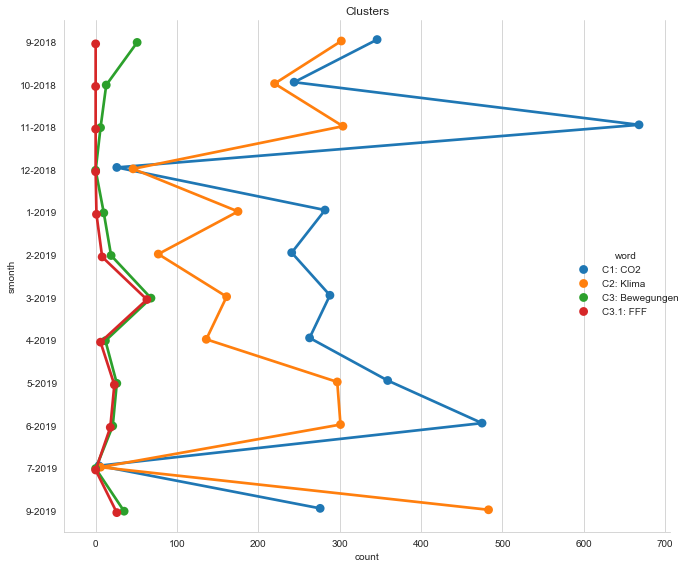

In [78]:
plotwords(["C1: CO2", "C2: Klima", "C3.1: FFF", "C3: Bewegungen"], title="Clusters")

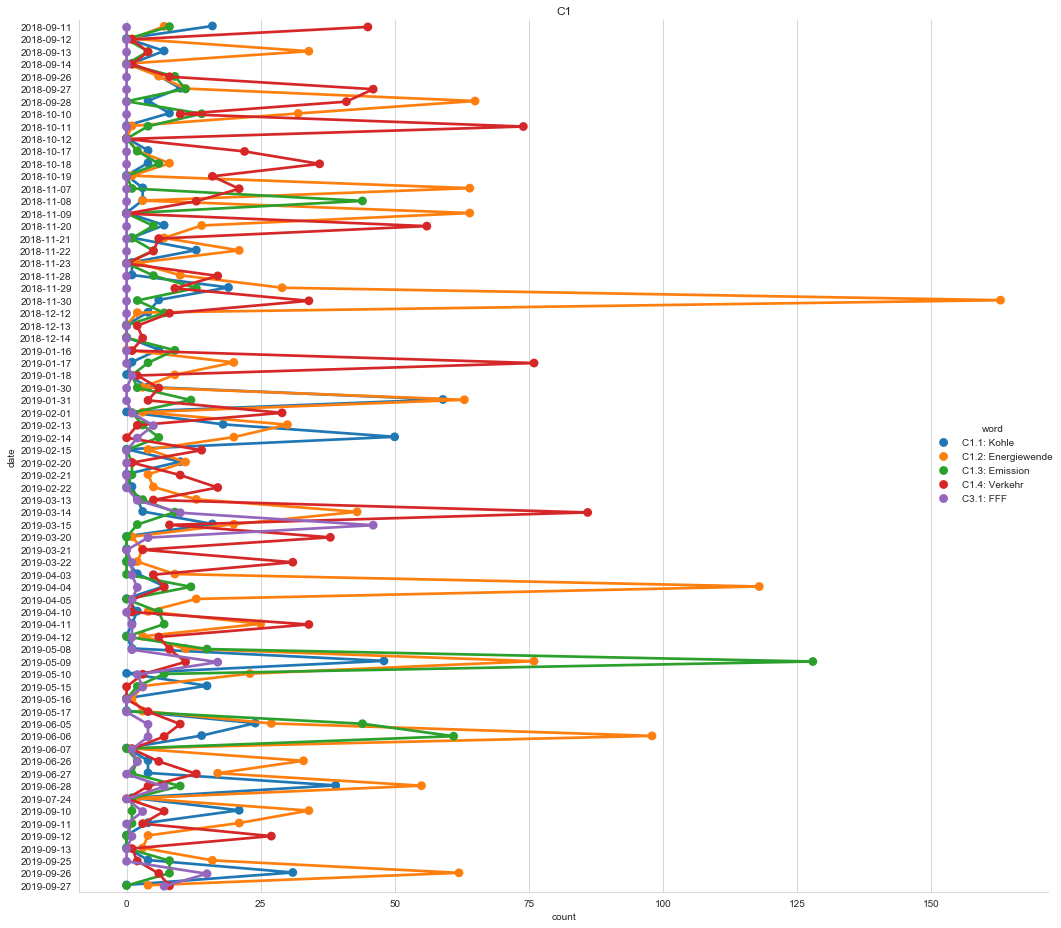

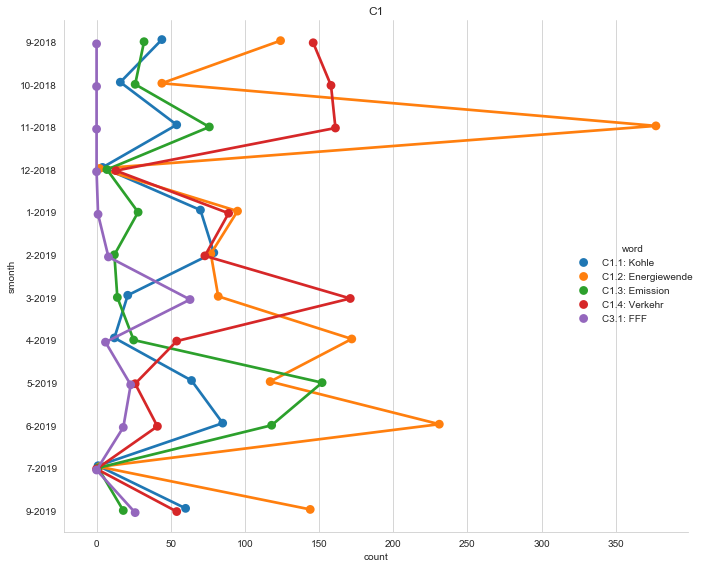

In [79]:
plotwords(["C1.1: Kohle", "C1.2: Energiewende", "C1.3: Emission", "C1.4: Verkehr", "C3.1: FFF"], title="C1")

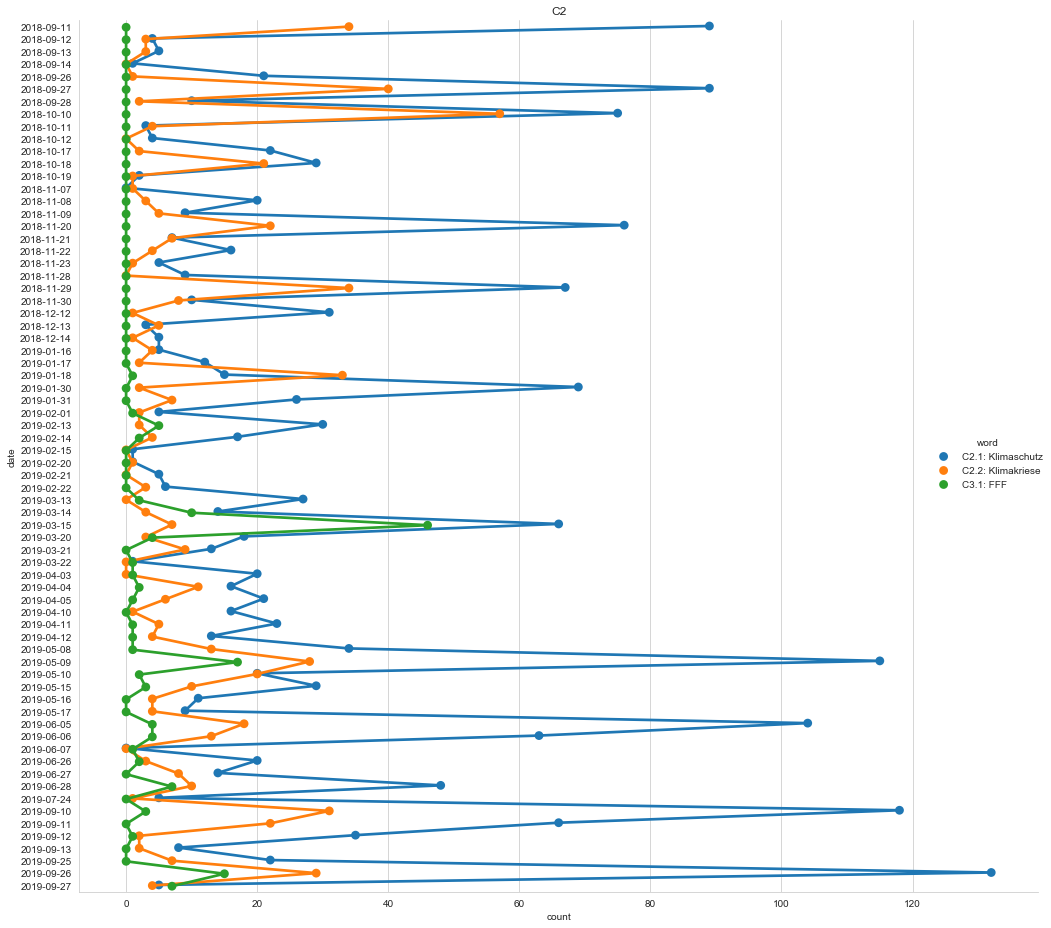

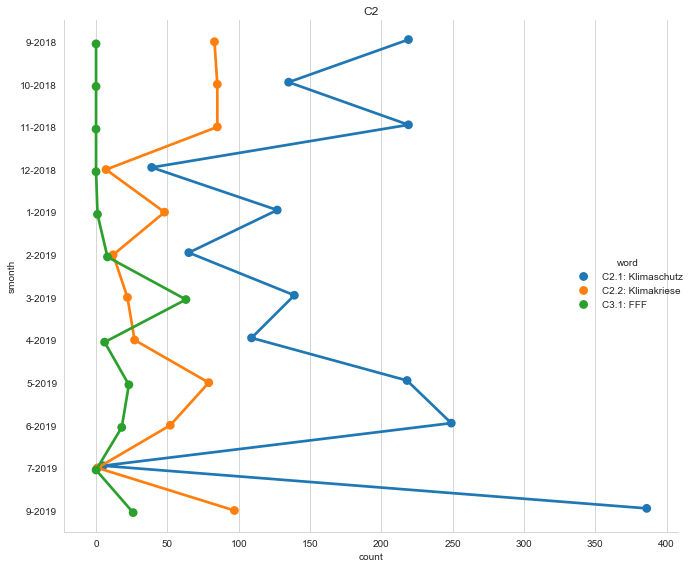

In [80]:
plotwords(["C2.1: Klimaschutz", "C2.2: Klimakriese", "C3.1: FFF"], title="C2")

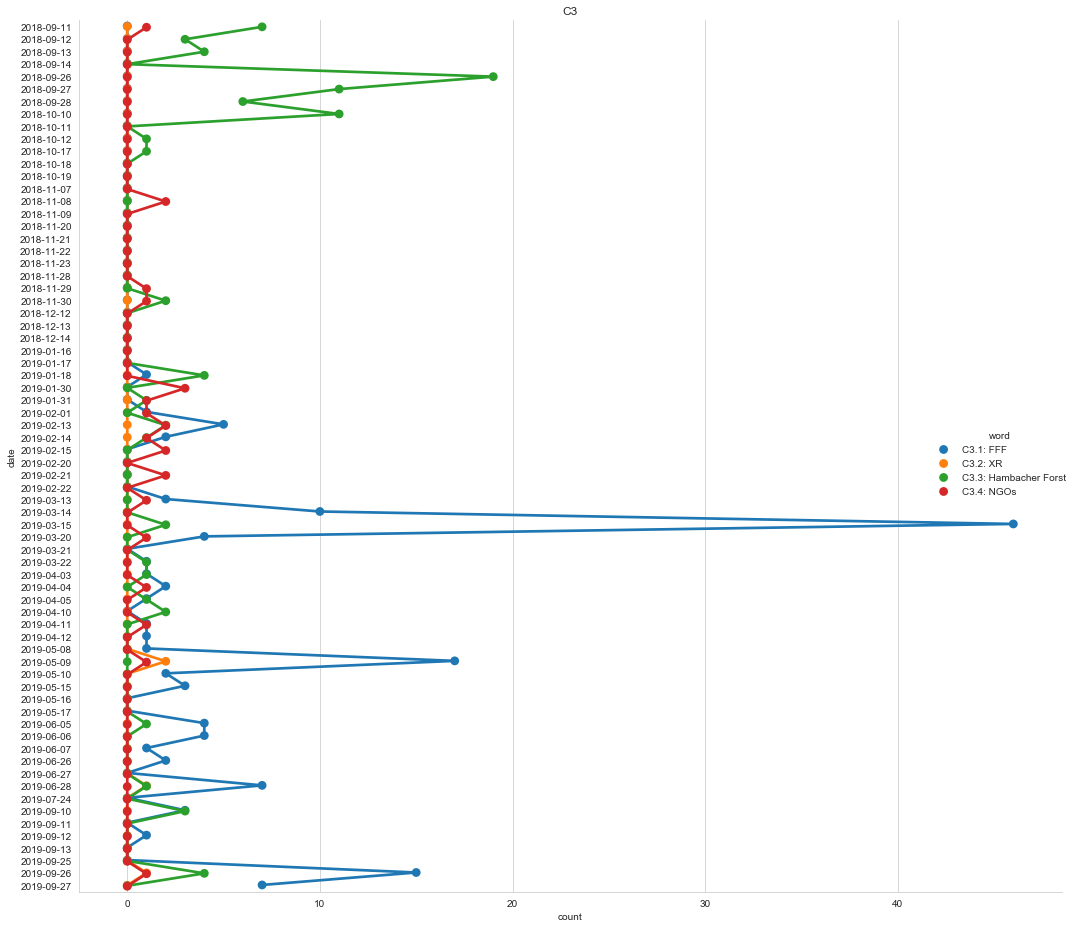

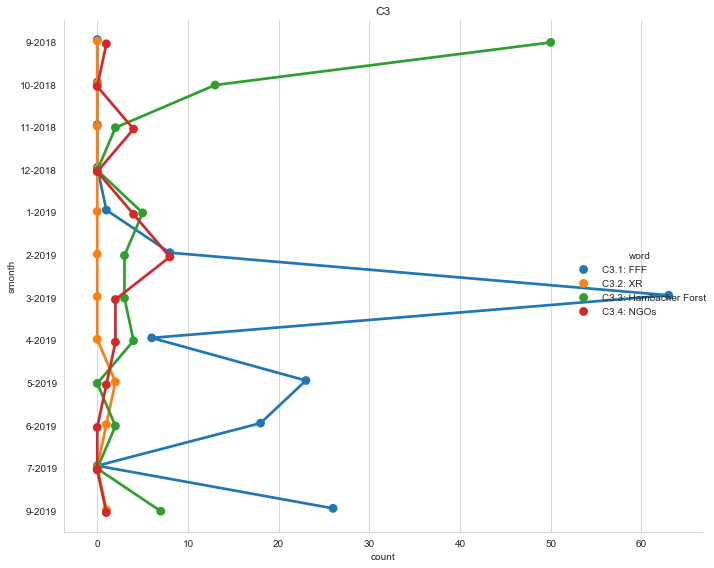

In [81]:
plotwords(["C3.1: FFF", "C3.2: XR", "C3.3: Hambacher Forst", "C3.4: NGOs"], title="C3")

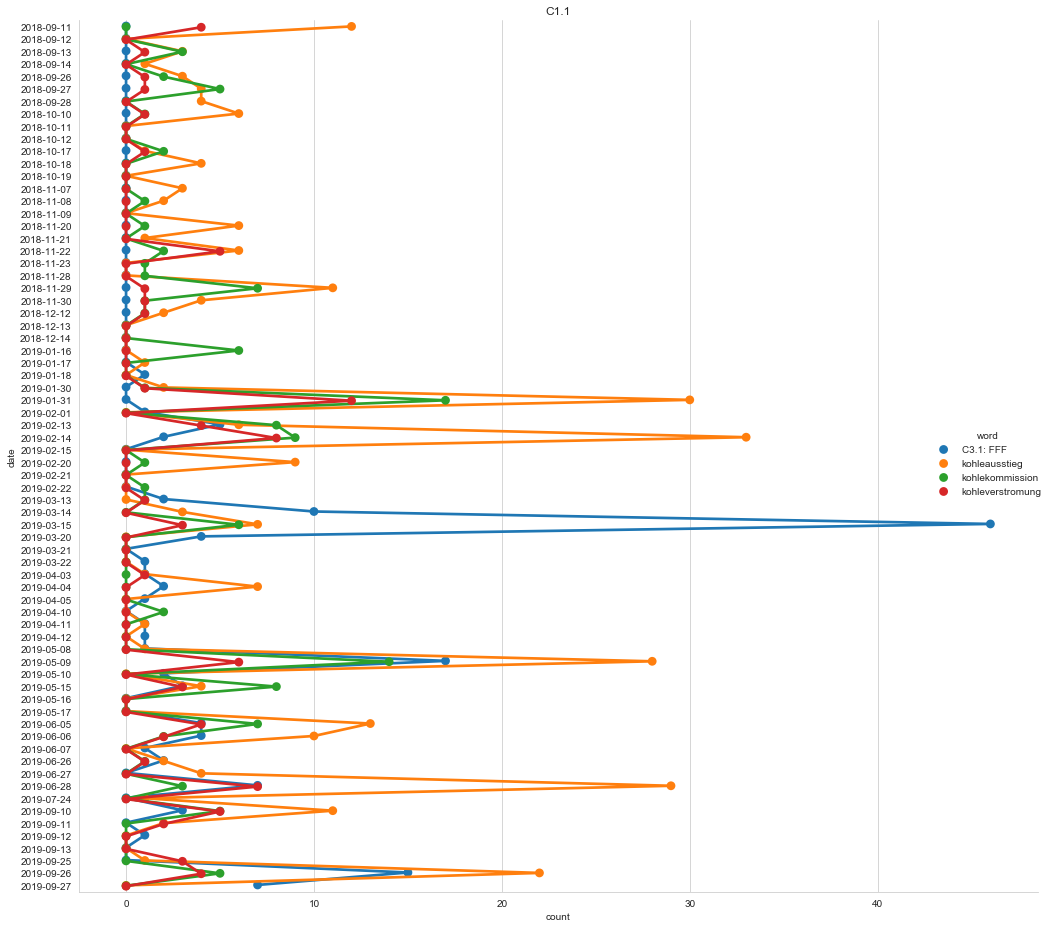

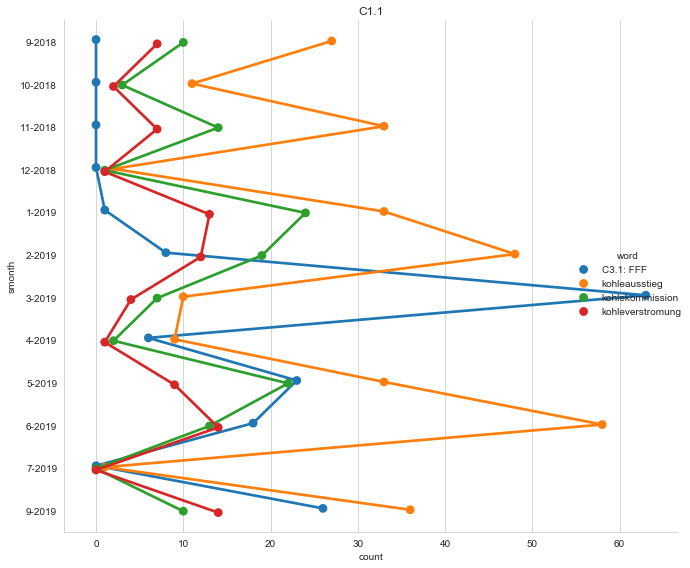

In [82]:
plotwords(c11 + ["C3.1: FFF"], title="C1.1")

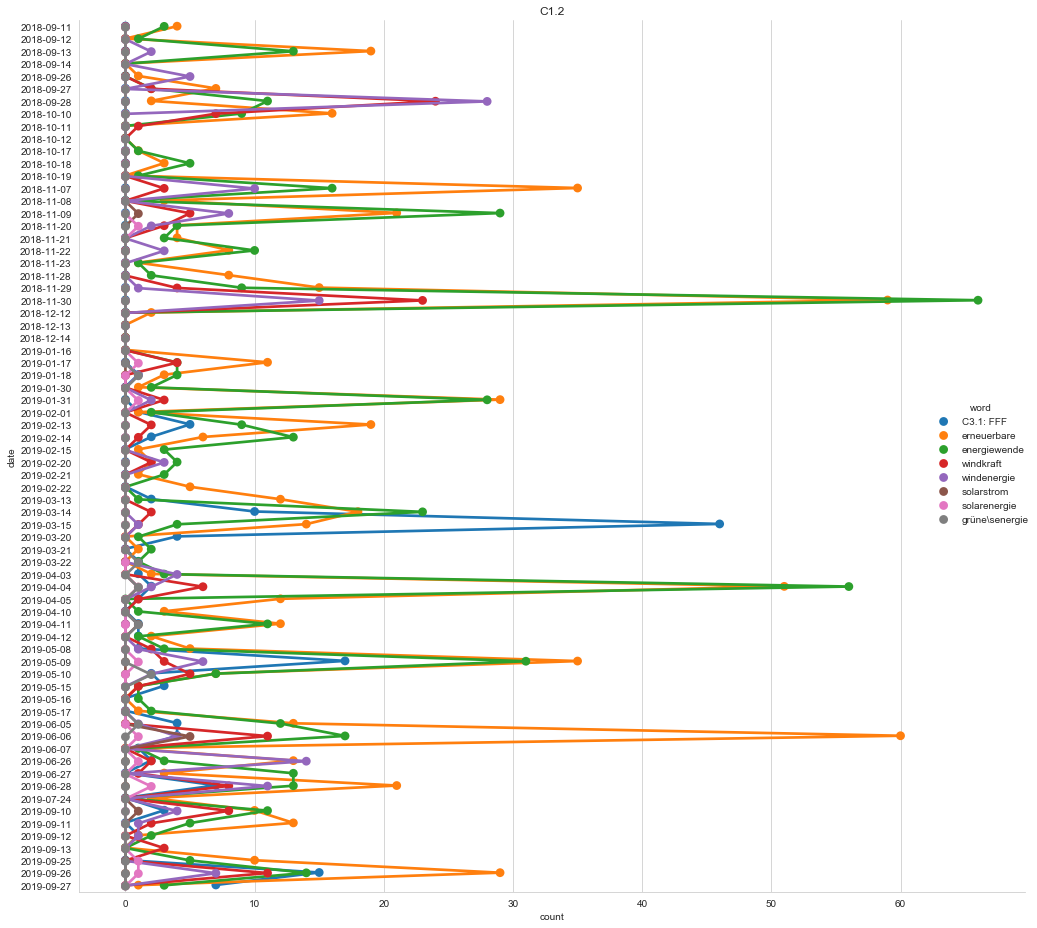

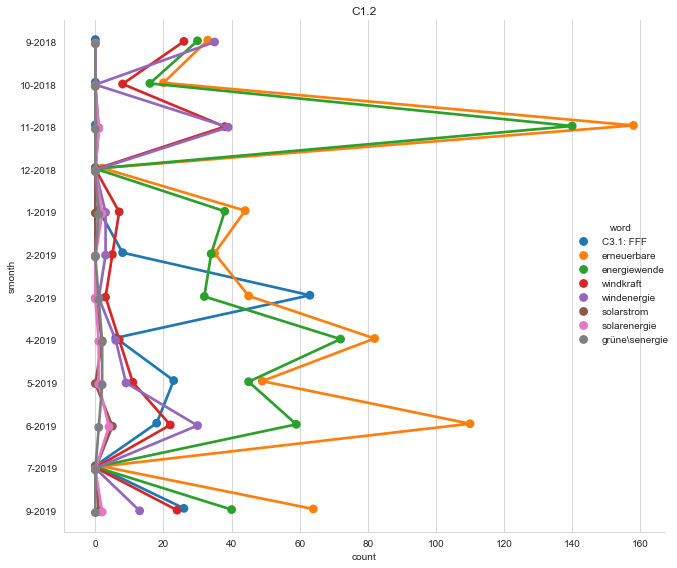

In [83]:
plotwords(c12 + ["C3.1: FFF"], title="C1.2")

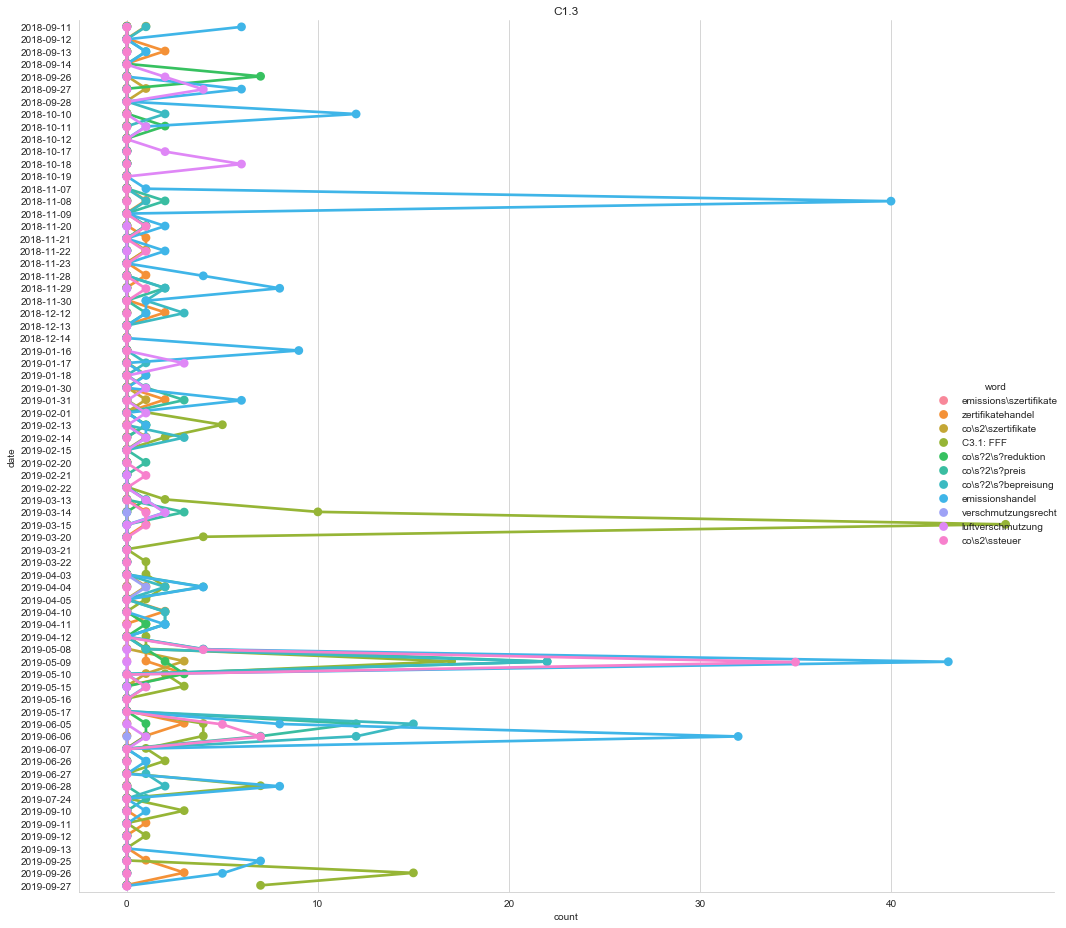

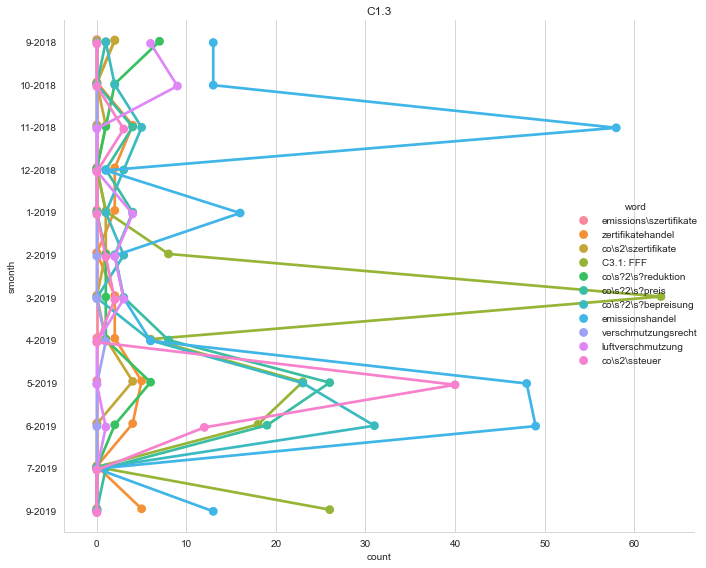

In [84]:
plotwords(c13 + ["C3.1: FFF"], title="C1.3")

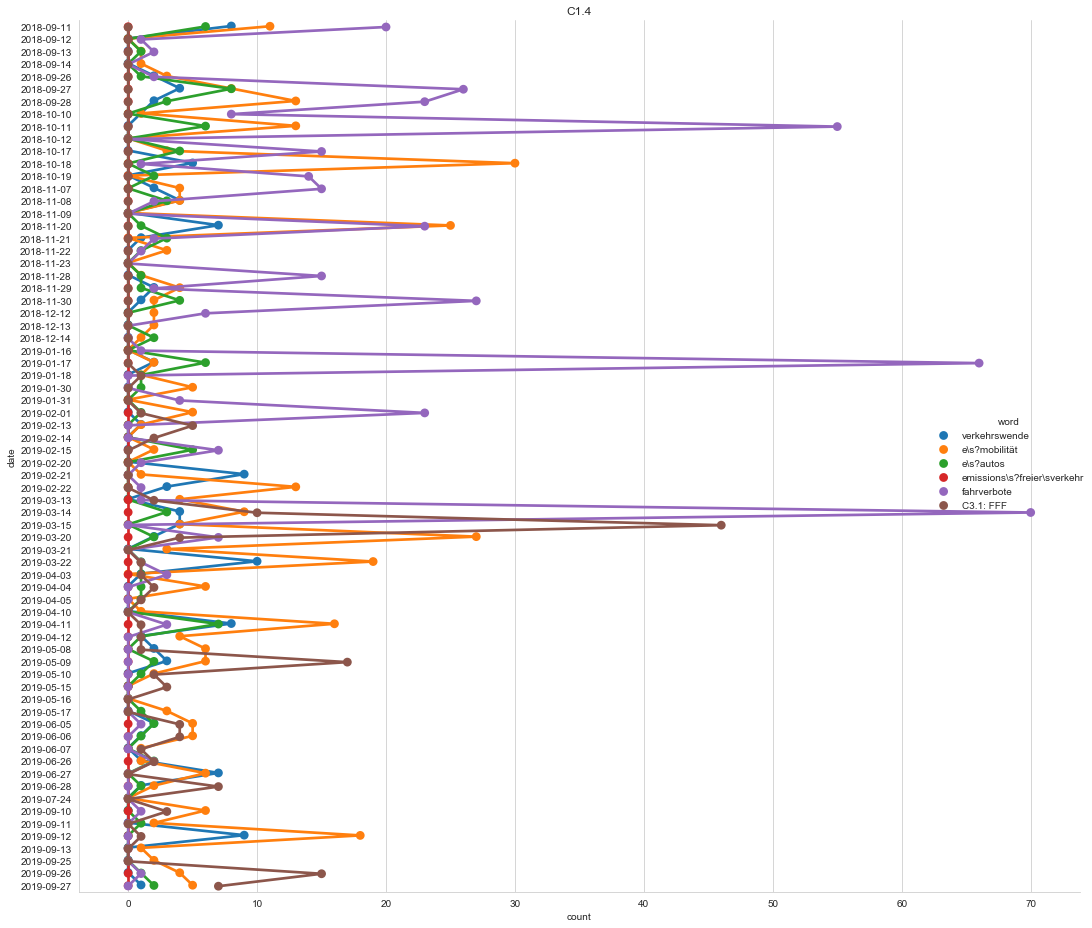

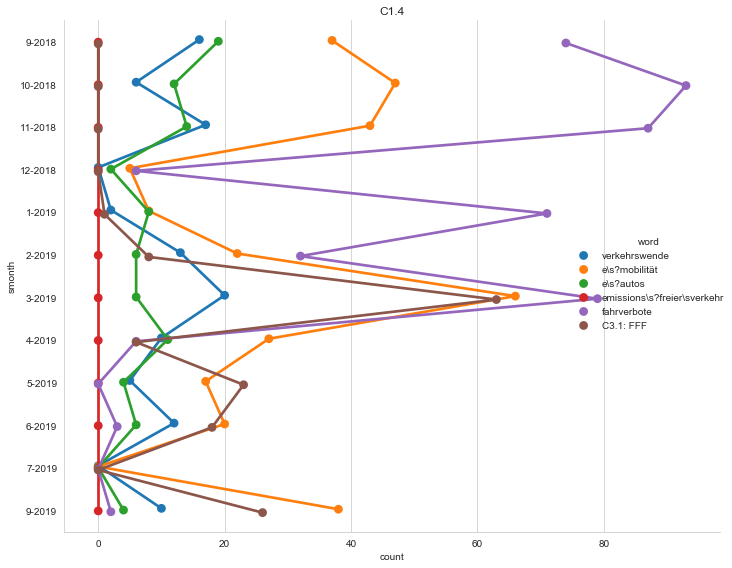

In [85]:
plotwords(c14 + ["C3.1: FFF"], title="C1.4")

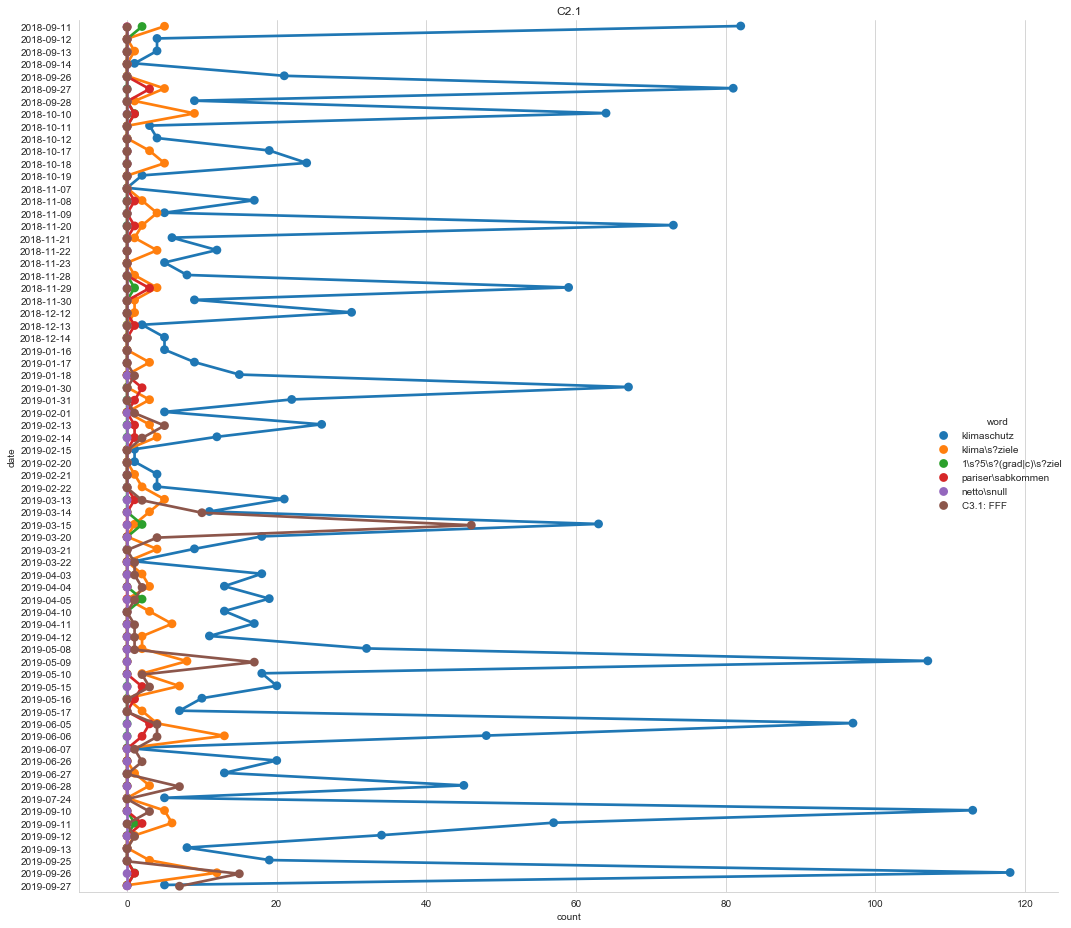

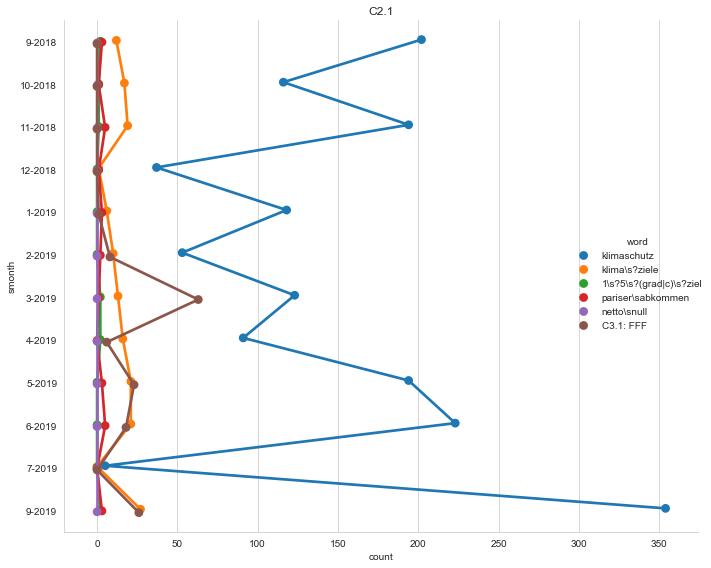

In [95]:
plotwords(c21 + ["C3.1: FFF"], title="C2.1")

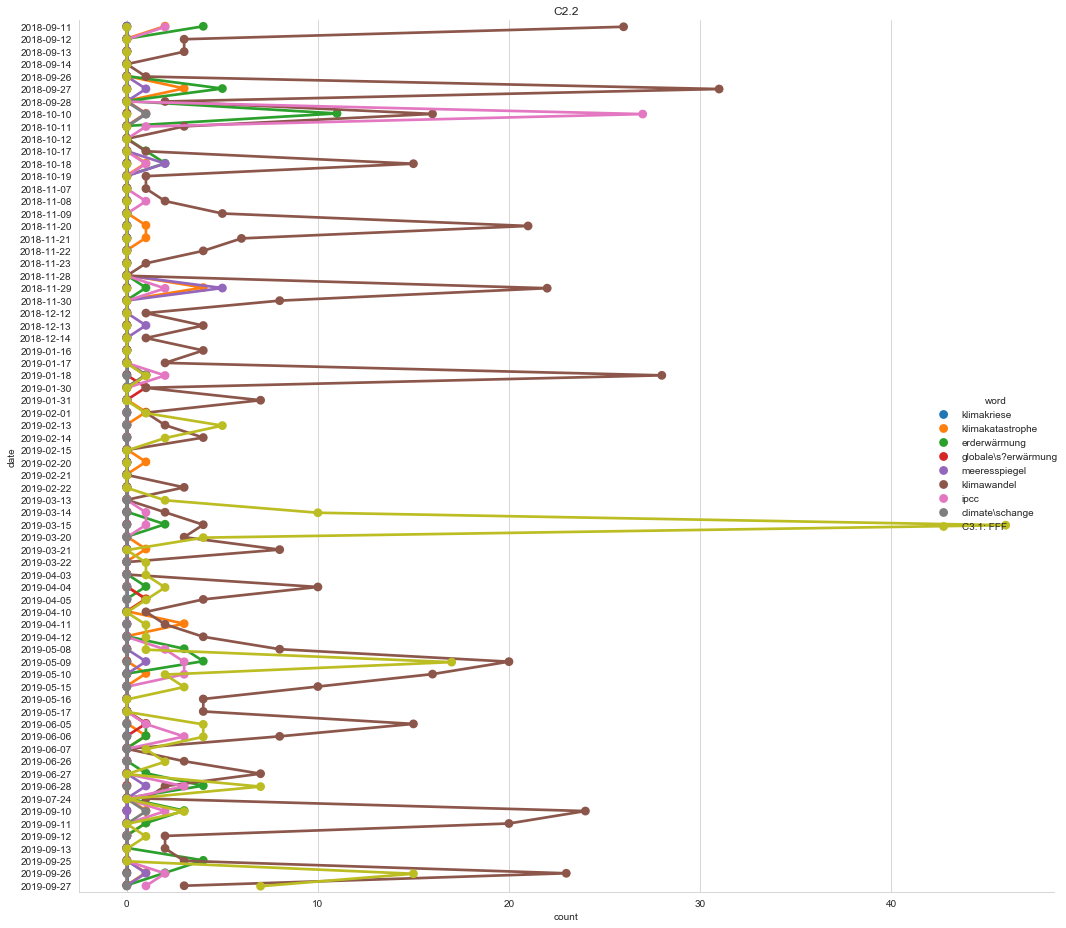

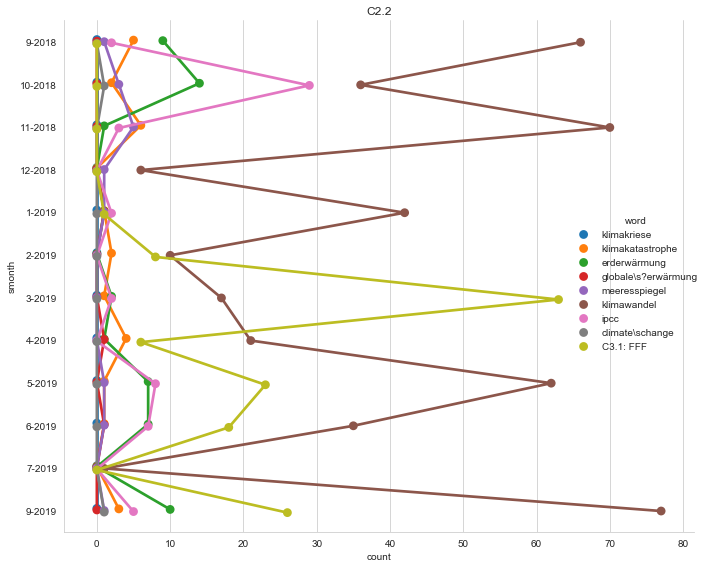

In [96]:
plotwords(c22 + ["C3.1: FFF"], title="C2.2")

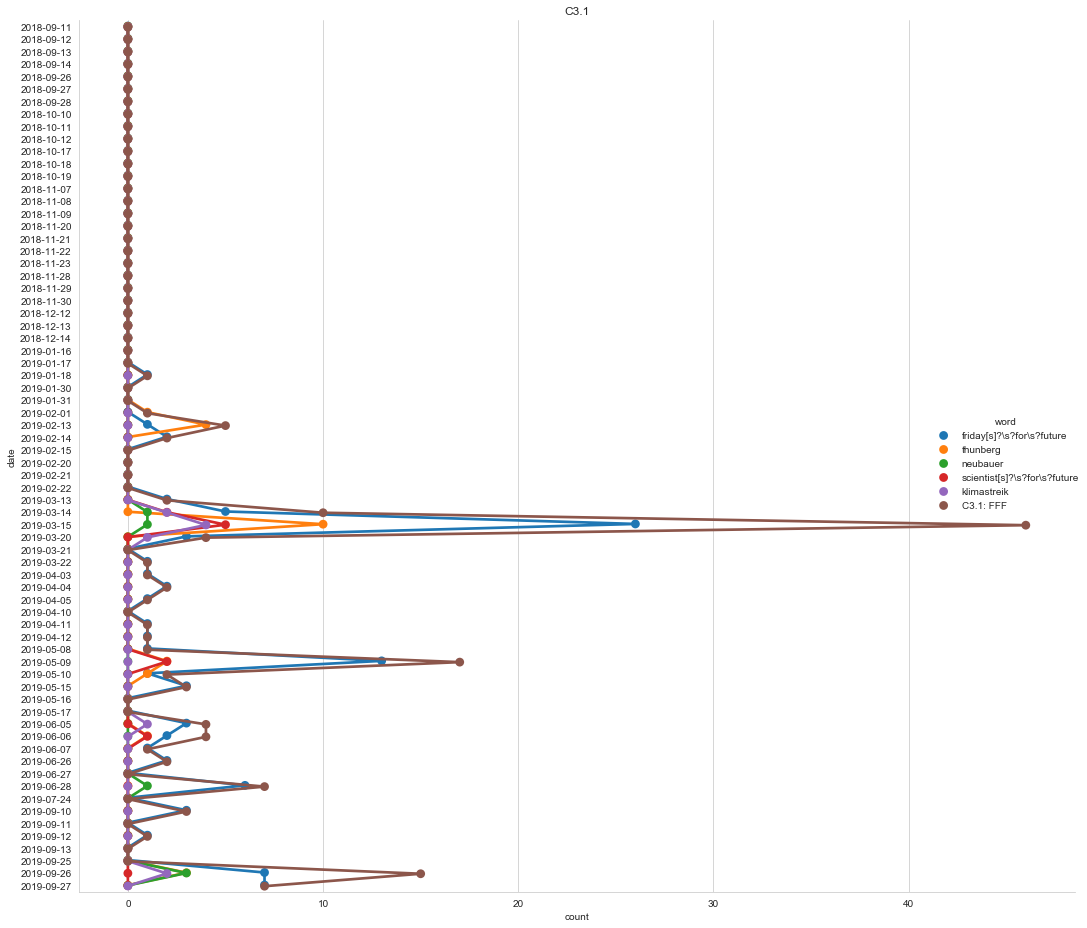

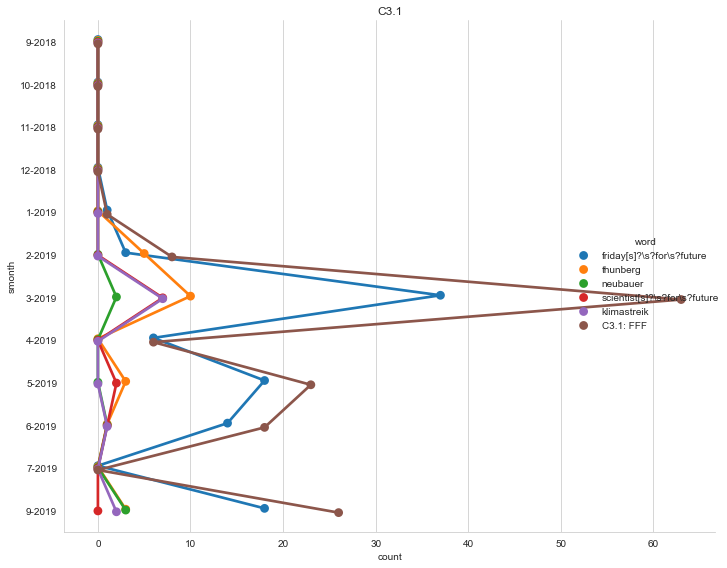

In [87]:
plotwords(c31 + ["C3.1: FFF"], title="C3.1")

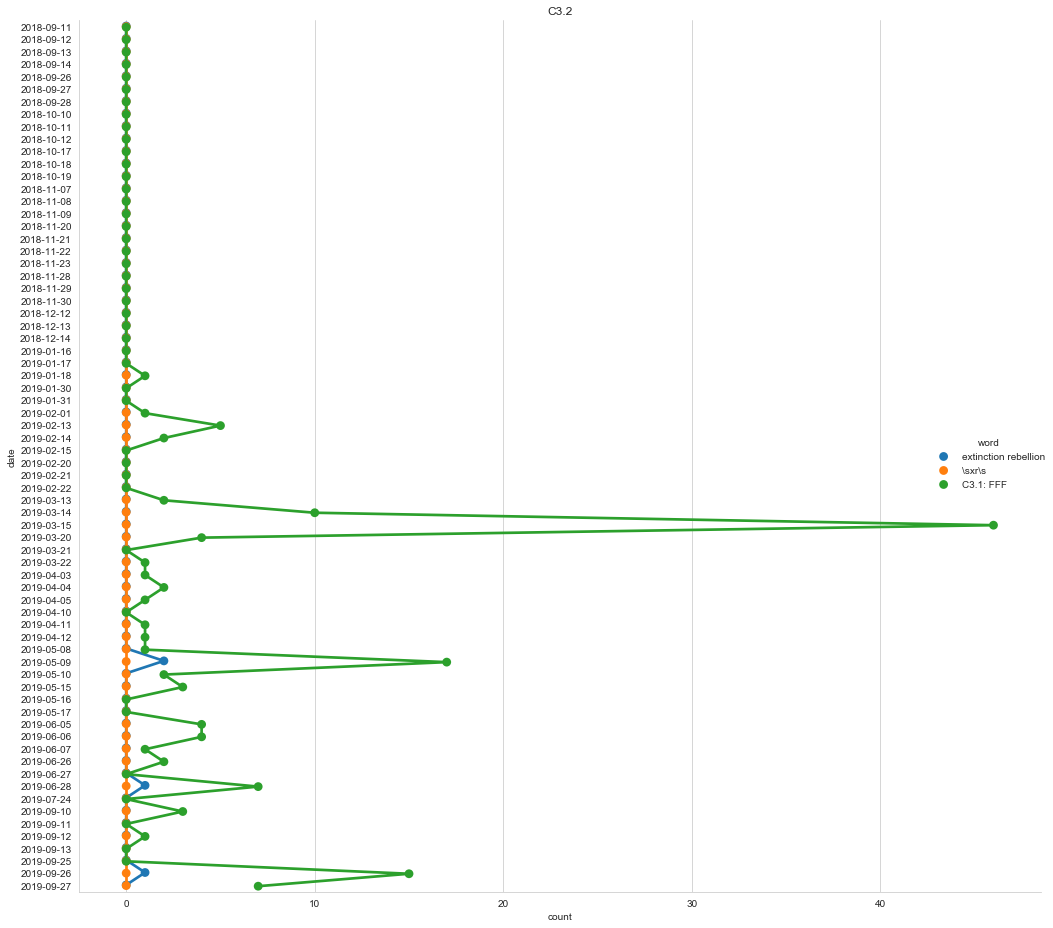

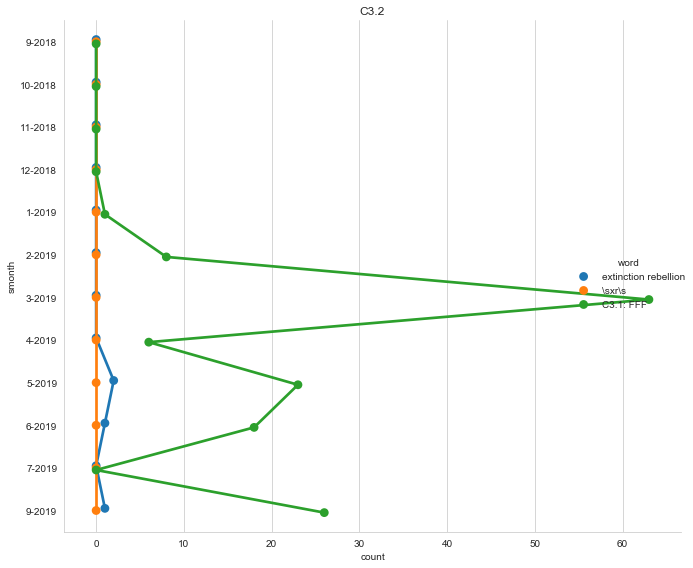

In [88]:
plotwords(c32 + ["C3.1: FFF"], title="C3.2")

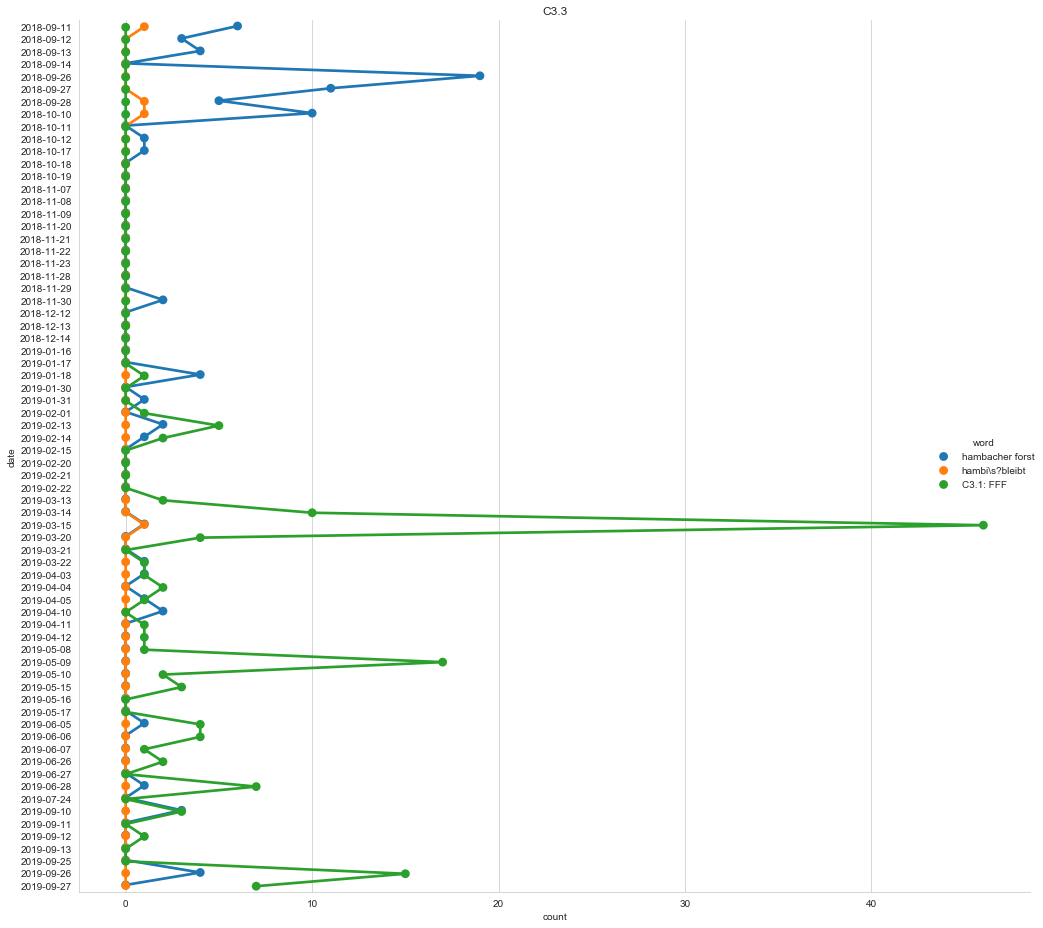

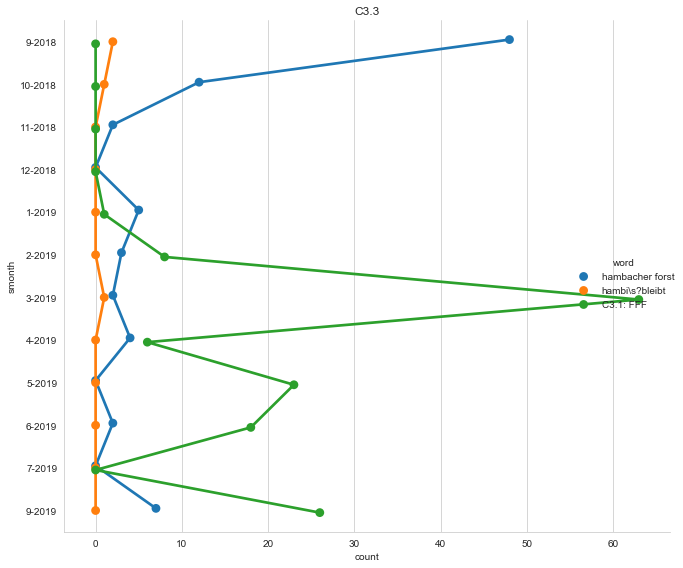

In [89]:
plotwords(c33 + ["C3.1: FFF"], title="C3.3")

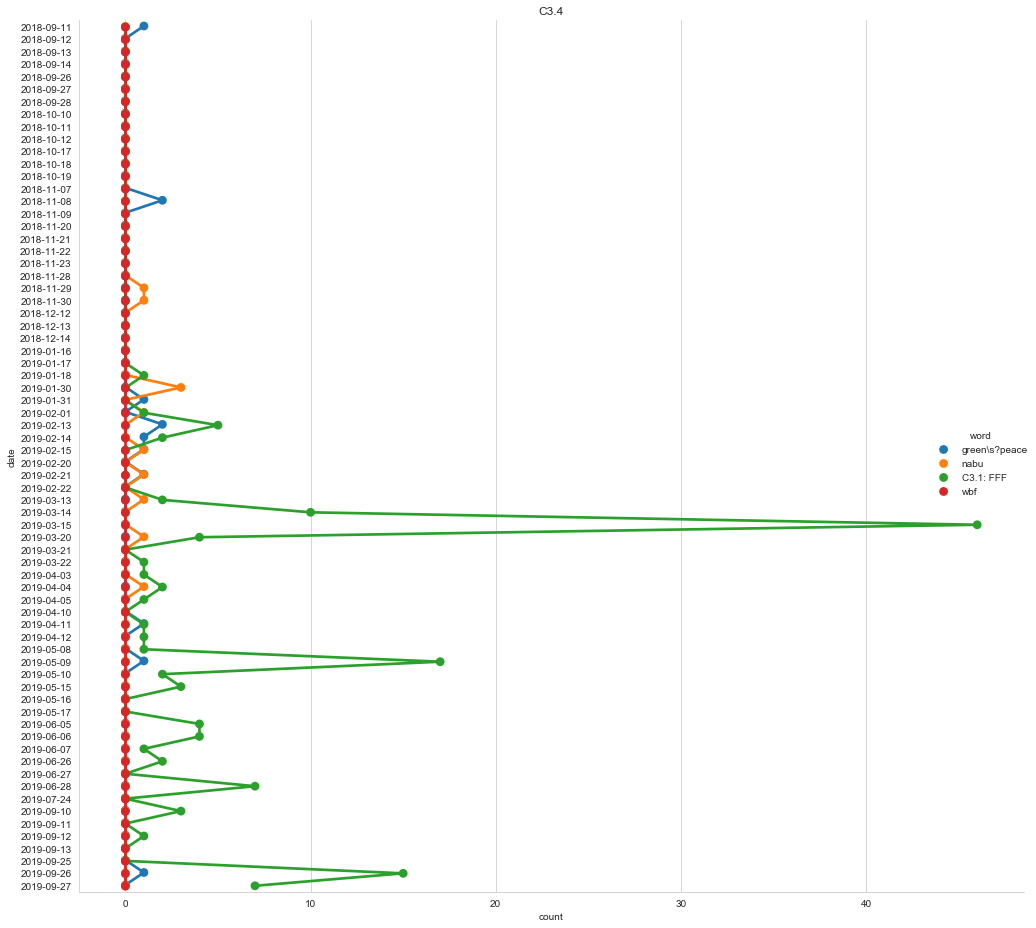

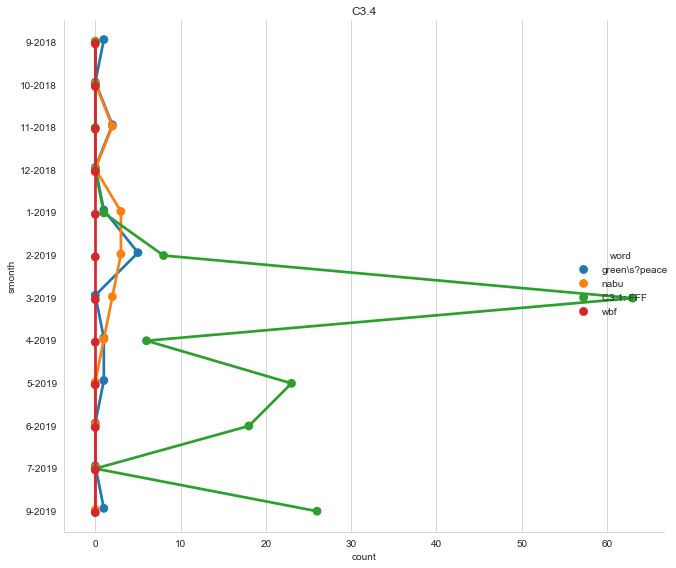

In [90]:
plotwords(c34 + ["C3.1: FFF"], title="C3.4")

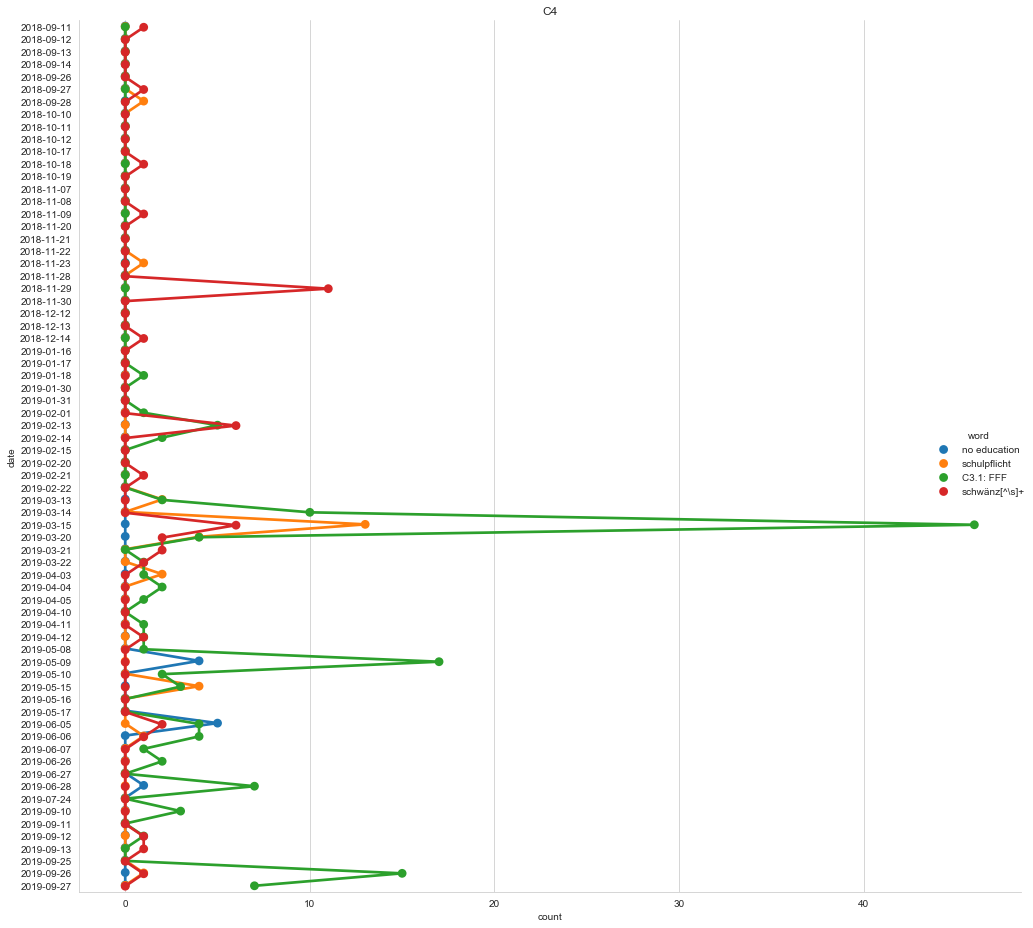

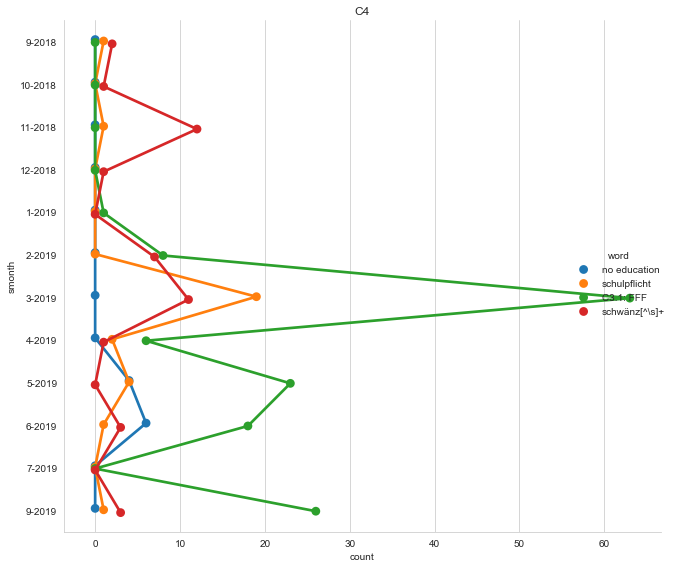

In [91]:
plotwords(c41 + ["C3.1: FFF"], title="C4")

In [92]:
IPython.display.display(df.groupby(["smonth", "word"]).sum()["count"])

smonth  word                   
1-2018  1\s?5\s?(grad|c)\s?ziel     1
        C1.1: Kohle                15
        C1.2: Energiewende         62
        C1.3: Emission              5
        C1.4: Verkehr               2
                                   ..
9-2019  verschmutzungsrecht         0
        wbf                         0
        windenergie                13
        windkraft                  24
        zertifikatehandel           5
Name: count, Length: 1273, dtype: int64

In [93]:
df.loc[df["count"] != 0]

date       sdate  smonth  day  year  month   nr  \
id                                                             
19006  2018-01-17  17.01.2018  1-2018   17  2018      1    6   
19006  2018-01-17  17.01.2018  1-2018   17  2018      1    6   
19006  2018-01-17  17.01.2018  1-2018   17  2018      1    6   
19006  2018-01-17  17.01.2018  1-2018   17  2018      1    6   
19006  2018-01-17  17.01.2018  1-2018   17  2018      1    6   
...           ...         ...     ...  ...   ...    ...  ...   
19116  2019-09-27  27.09.2019  9-2019   27  2019      9  116   
19116  2019-09-27  27.09.2019  9-2019   27  2019      9  116   
19116  2019-09-27  27.09.2019  9-2019   27  2019      9  116   
19116  2019-09-27  27.09.2019  9-2019   27  2019      9  116   
19116  2019-09-27  27.09.2019  9-2019   27  2019      9  116   

                          word  count  
id                                     
19006              fahrverbote      1  
19006              klimaschutz      9  
19006            klima\s?ziele      2  
19006  1\s?5\s?(grad|c)\s?ziel      1  
19006            meeresspiegel      1  
...                        ...    ...  
19116              klimawandel      3  
19116              klimaschutz      5  
19116                e\s?autos      2  
19116            e\s?mobilität      5  
19116            verkehrswende      1  

[2220 rows x 9 columns]

In [94]:
a = df.loc[df.word == "fff"]
a.loc[a["count"] > 0]["date"]

Series([], Name: date, dtype: object)

In [24]:
len(df_filter["date"].unique())

NameError: name 'df_filter' is not defined

In [ ]:
# erste nennung fff
# anzahl plenardebatten sept 2018 bis sept 2019
# 